In [ ]:
!pip install geopandas
!pip install pysal
!pip install overpass
!pip install osmnx

     |████████████████████████████████| 1.0MB 4.2MB/s 
     |████████████████████████████████| 15.3MB 222kB/s 
     |████████████████████████████████| 6.5MB 42.5MB/s 
     |████████████████████████████████| 92kB 10.9MB/s 
  Found existing installation: click 8.0.0
    Uninstalling click-8.0.0:
      Successfully uninstalled click-8.0.0
     |████████████████████████████████| 2.4MB 5.7MB/s 
     |████████████████████████████████| 112kB 42.4MB/s 
     |████████████████████████████████| 61kB 7.0MB/s 
     |████████████████████████████████| 61kB 6.0MB/s 
     |████████████████████████████████| 92kB 10.0MB/s 
     |████████████████████████████████| 51kB 6.4MB/s 
     |████████████████████████████████| 51kB 6.1MB/s 
     |████████████████████████████████| 215kB 37.2MB/s 
     |████████████████████████████████| 5.7MB 20.1MB/s 
     |████████████████████████████████| 61kB 6.8MB/s 
     |████████████████████████████████| 153kB 50.0MB/s 
     |████████████████████████████████| 235kB 46.9MB/s 
  

     |████████████████████████████████| 133kB 5.3MB/s 
ERROR: pysal 2.4.0 has requirement urllib3>=1.26, but you'll have urllib3 1.25.11 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: urllib3 1.26.4
    Uninstalling urllib3-1.26.4:
      Successfully uninstalled urllib3-1.26.4
     |████████████████████████████████| 102kB 4.2MB/s 
     |████████████████████████████████| 10.3MB 8.6MB/s 
     |████████████████████████████████| 61kB 6.5MB/s 
ERROR: pysal 2.4.0 has requirement urllib3>=1.26, but you'll have urllib3 1.25.11 which is incompatible.
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompa

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

from shapely.geometry import Point, LineString, Polygon, MultiPoint, MultiLineString, MultiPolygon
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from geopy.geocoders import Nominatim
import networkx as nx
import osmnx as ox
ox.config(log_console=True, use_cache=True)
ox.__version__

'1.1.1'

# Загрузка данных

In [ ]:
# Считается очень долго, внизу ниже уже будут файлы готовые

!wget http://gisgeo.org/assets/files/Regions_geojson.zip -O ./Regions_geojson.zip  # административные границы регионов
!wget https://raw.githubusercontent.com/andrey-source/tehnopark/main/geo_hw/mf_geo_test.csv -O./test.csv  # тестовые данные
!wget https://raw.githubusercontent.com/andrey-source/tehnopark/main/geo_hw/mf_geo_train.csv -O./train.csv  # тренировочные данные
!wget https://raw.githubusercontent.com/andrey-source/tehnopark/main/geo_hw/sample_submission.csv -O./submission.csv  # сабмит

--2021-05-20 18:54:12--  http://gisgeo.org/assets/files/Regions_geojson.zip
Resolving gisgeo.org (gisgeo.org)... 195.24.68.29
Connecting to gisgeo.org (gisgeo.org)|195.24.68.29|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7897038 (7.5M) [application/zip]
Saving to: ‘./Regions_geojson.zip’

./Regions_geojson.z 100%[===================>]   7.53M  2.82MB/s    in 2.7s    

2021-05-20 18:54:16 (2.82 MB/s) - ‘./Regions_geojson.zip’ saved [7897038/7897038]

--2021-05-20 18:54:16--  https://raw.githubusercontent.com/andrey-source/tehnopark/main/geo_hw/mf_geo_test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4462 (4.4K) [text/plain]
Saving to: ‘./test.csv’

./test.csv          100%[===================>]   4.36K  --.-KB/s    in 0s   

In [ ]:

regions = gpd.read_file('Regions_geojson.zip')  # границы регионов
gdf = gpd.read_file('train.csv')
test_gdf = gpd.read_file('test.csv')


# Работа с данными

In [ ]:
gdf.lon = gdf.lon.astype(float)
gdf.lat = gdf.lat.astype(float)
gdf['geometry'] = [Point(x, y) for x, y in zip(gdf.lon, gdf.lat)]
gdf = gpd.sjoin(gdf, regions[['NAME', 'geometry']], op='within')
gdf.head()

,point_id,lon,lat,target,geometry,index_right,NAME
0,ommNZCUV,37.590776,55.848630,-0.34815737860381524,POINT (37.59078 55.84863),41,Москва
1,nMe2LHPb,37.784210,55.750271,1.294206304946465,POINT (37.78421 55.75027),41,Москва
3,0t2jNYdz,37.704570,55.782020,-1.1693392203789554,POINT (37.70457 55.78202),41,Москва
4,U27W4QJ7,37.643983,55.730188,-0.08883679699061309,POINT (37.64398 55.73019),41,Москва
7,CO76tdVs,37.444304,55.850511,0.21370388155812275,POINT (37.44430 55.85051),41,Москва


## Расчет обучающей выборки

In [ ]:
gdf['bus_stop_300'] = np.nan  # автобусные остановки в радиусе 300 м (много бабок = много фичерфонов)
gdf['n_mobile'] = np.nan  # магазины телефонов
gdf['n_electronics'] = np.nan  # магазины электроники
gdf['railway'] = np.nan  # расстояние до ближайшей станции (пешком)
gdf['n_railway'] = np.nan  # число станций в радиусе 1км

In [ ]:
# Считаю автобусные остановки (очень долго)
for i in tqdm(range(gdf.shape[0])):
    bus_df = ox.geometries_from_point(center_point=[gdf.lat[i], gdf.lon[i]],  tags={'highway': 'bus_stop'}, dist = 300)
    gdf.bus_stop_300[i] = bus_df.shape[0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.p

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
# Считаю магазины телефонов (очень долго)
for i in tqdm(range(gdf.shape[0])):
    mobile_df = ox.geometries_from_point(center_point=[gdf.lat[i], gdf.lon[i]],  tags={'shop': 'mobile_phone'}, dist = 1000)
    gdf.n_mobile[i] = mobile_df.shape[0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.p

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
# Считаю магазины электроники (очень долго)
for i in tqdm(range(gdf.shape[0])):
    electronics_df = ox.geometries_from_point(center_point=[gdf.lat[i], gdf.lon[i]],  tags={'shop': 'electronics'}, dist = 1000)
    gdf.n_electronics[i] = electronics_df.shape[0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.p

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
# Считаю расстояние до ближайшей станции, и число станций в радиусе 3км (оч долго считается)
for i in tqdm(range(gdf.shape[0])):
    train = ox.geometries_from_point(center_point=[gdf.lat[i], gdf.lon[i]],  tags={'railway': 'station'}, dist = 3000)  # ищу станции в радиусе 3 км
    if train.shape[0] > 0:
        G = ox.graph.graph_from_point(center_point=[gdf.lat[i], gdf.lon[i]], dist=3000, network_type='walk')
        shop_node = ox.distance.get_nearest_node(G, point=[gdf.lat[i], gdf.lon[i]], return_dist=True)  # ближайший узел к магазину
        S = []
        for j in range(train.shape[0]):
            try:
                train_node = ox.distance.get_nearest_node(G, point=[train.geometry[j].y, train.geometry[j].x], return_dist=True)  # ближайший узел к станции (станций может быть несколько)
            except:
                train_node = ox.distance.get_nearest_node(G, point=[train.geometry[j].centroid.y, train.geometry[j].centroid.x], return_dist=True)  # ближайший узел к станции (станций может быть несколько)
            route = ox.distance.shortest_path(G, shop_node[0], train_node[0])
            dists = ox.utils_graph.get_route_edge_attributes(G, route=route, attribute='length')
            S.append(sum(dists))
        gdf.railway[i] = min(S) # минимальное расстояние
        gdf.n_railway[i] = len(S)

Выходные данные были обрезаны до нескольких последних строк (5000).
/usr/local/lib/python3.7/dist-packages/osmnx/distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/osmnx/distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be se

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## Расчет тестовой выборки

In [ ]:
test_gdf.lon = test_gdf.lon.astype(float)
test_gdf.lat = test_gdf.lat.astype(float)
test_gdf['geometry'] = [Point(x, y) for x, y in zip(test_gdf.lon, test_gdf.lat)]
test_gdf = gpd.sjoin(test_gdf, regions[['NAME', 'geometry']], op='within')
test_gdf.head()

,point_id,lon,lat,target,geometry,index_right,NAME
0,F4lXR1cG,37.681242,55.748040,0.0091,POINT (37.68124 55.74804),41,Москва
2,kLuAAN3s,37.598614,55.781357,0.0091,POINT (37.59861 55.78136),41,Москва
3,OxQHvaNu,37.794051,55.717468,0.0091,POINT (37.79405 55.71747),41,Москва
5,7x7uZwPc,37.617141,55.795433,0.0091,POINT (37.61714 55.79543),41,Москва
7,OMCMewkC,37.798028,55.810580,0.0091,POINT (37.79803 55.81058),41,Москва


In [ ]:
test_gdf['bus_stop_300'] = np.nan  # автобусные остановки в радиусе 300 м (много бабок = много фичерфонов)
test_gdf['n_mobile'] = np.nan  # магазины телефонов
test_gdf['n_electronics'] = np.nan  # магазины электроники
test_gdf['railway'] = np.nan  # расстояние до ближайшей станции (пешком)
test_gdf['n_railway'] = np.nan  # число станций в радиусе 3 км

In [ ]:
# Считаю автобусные остановки (оч долго)
for i in tqdm(range(test_gdf.shape[0])):
    bus_df = ox.geometries_from_point(center_point=[test_gdf.lat[i], test_gdf.lon[i]],  tags={'highway': 'bus_stop'}, dist = 300)
    test_gdf.bus_stop_300[i] = bus_df.shape[0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.p

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
# Считаю магазины телефонов (оч долго)
for i in tqdm(range(test_gdf.shape[0])):
    mobile_df = ox.geometries_from_point(center_point=[test_gdf.lat[i], test_gdf.lon[i]],  tags={'shop': 'mobile_phone'}, dist = 1000)
    test_gdf.n_mobile[i] = mobile_df.shape[0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.p

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
# Считаю магазины электроники (оч долго)
for i in tqdm(range(test_gdf.shape[0])):
    electronics_df = ox.geometries_from_point(center_point=[test_gdf.lat[i], test_gdf.lon[i]],  tags={'shop': 'electronics'}, dist = 1000)
    test_gdf.n_electronics[i] = electronics_df.shape[0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.p

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
# Считаю расстояние до ближайшей станции, и число станций в радиусе 1км (оч долго считается)
for i in tqdm(range(test_gdf.shape[0])):
    train = ox.geometries_from_point(center_point=[test_gdf.lat[i], test_gdf.lon[i]],  tags={'railway': 'station'}, dist = 3000)  # ищу станции в радиусе 3 км
    if train.shape[0] > 0:
        G = ox.graph.graph_from_point(center_point=[test_gdf.lat[i], test_gdf.lon[i]], dist=3000, network_type='walk')
        shop_node = ox.distance.get_nearest_node(G, point=[test_gdf.lat[i], test_gdf.lon[i]], return_dist=True)  # ближайший узел к магазину
        S = []
        for j in range(train.shape[0]):
            try:
                train_node = ox.distance.get_nearest_node(G, point=[train.geometry[j].y, train.geometry[j].x], return_dist=True)  # ближайший узел к станции (станций может быть несколько)
            except:
                train_node = ox.distance.get_nearest_node(G, point=[train.geometry[j].centroid.y, train.geometry[j].centroid.x], return_dist=True)  # ближайший узел к станции (станций может быть несколько)
            route = ox.distance.shortest_path(G, shop_node[0], train_node[0])
            dists = ox.utils_graph.get_route_edge_attributes(G, route=route, attribute='length')
            S.append(sum(dists))
        test_gdf.railway[i] = min(S) # минимальное расстояние
        test_gdf.n_railway[i] = len(S)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/usr/local/lib/python3.7/dist-packages/osmnx/distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/osmnx/distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/osmnx/distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/osmnx/distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)
/usr/local/lib/p

# Загрузка ранее вычисленных данных

In [ ]:
# !wget https://raw.githubusercontent.com/andrey-source/tehnopark/main/geo_hw/gdf.csv -O ./gdf.csv  # уже посчитанная обучающая таблица с радиусом 1000
# !wget https://raw.githubusercontent.com/andrey-source/tehnopark/main/geo_hw/test_gdf.csv -O ./test_gdf.csv  # уже посчитанные тестовые данные с радиусом 1000


!wget https://raw.githubusercontent.com/andrey-source/tehnopark/main/geo_hw/gdf_3000.csv -O ./gdf.csv  # уже посчитанная таблица с радиусом 3000
!wget https://raw.githubusercontent.com/andrey-source/tehnopark/main/geo_hw/test_gdf_3000.csv -O ./test_gdf.csv  # уже посчитанная тестовая таблица с радиусом 3000

gdf = gpd.read_file('gdf.csv', GEOM_POSSIBLE_NAMES="geometry", KEEP_GEOM_COLUMNS="NO")
test_gdf = gpd.read_file('test_gdf.csv', GEOM_POSSIBLE_NAMES="geometry", KEEP_GEOM_COLUMNS="NO")

--2021-05-20 18:56:29--  https://raw.githubusercontent.com/andrey-source/tehnopark/main/geo_hw/gdf_3000.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64001 (63K) [text/plain]
Saving to: ‘./gdf.csv’

./gdf.csv           100%[===================>]  62.50K  --.-KB/s    in 0.01s   

2021-05-20 18:56:29 (4.51 MB/s) - ‘./gdf.csv’ saved [64001/64001]

--2021-05-20 18:56:29--  https://raw.githubusercontent.com/andrey-source/tehnopark/main/geo_hw/test_gdf_3000.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14754 (14K) [text/plai

In [ ]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 425 entries, 0 to 424
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   field_1        425 non-null    object  
 1   point_id       425 non-null    object  
 2   lon            425 non-null    object  
 3   lat            425 non-null    object  
 4   target         425 non-null    object  
 5   index_right    425 non-null    object  
 6   NAME           425 non-null    object  
 7   bus_stop_300   425 non-null    object  
 8   railway        425 non-null    object  
 9   n_railway      425 non-null    object  
 10  n_mobile       425 non-null    object  
 11  n_electronics  425 non-null    object  
 12  geometry       425 non-null    geometry
dtypes: geometry(1), object(12)
memory usage: 43.3+ KB


In [ ]:
# Перевожу в инты и заполняю пропуски
gdf.bus_stop_300 = gdf.bus_stop_300.astype(float)
gdf.n_mobile = gdf.n_mobile.astype(float)
gdf.n_electronics = gdf.n_electronics.astype(float)
gdf.railway[gdf.railway.values == ''] = 7000
gdf.n_railway[gdf.n_railway == ''] = 0
gdf.railway = gdf.railway.astype(float)
gdf.n_railway = gdf.n_railway.astype(float)
gdf.lat = gdf.lat.astype(float)
gdf.lon = gdf.lon.astype(float)
gdf.target = gdf.target.astype(float)

test_gdf.bus_stop_300 = test_gdf.bus_stop_300.astype(float)
test_gdf.n_mobile = test_gdf.n_mobile.astype(float)
test_gdf.n_electronics = test_gdf.n_electronics.astype(float)
test_gdf.railway[test_gdf.railway.values == ''] = 7000
test_gdf.n_railway[test_gdf.n_railway == ''] = 0
test_gdf.railway = test_gdf.railway.astype(float)
test_gdf.n_railway = test_gdf.n_railway.astype(float)
test_gdf.target = test_gdf.target.astype(float)

# Визуализация

/usr/local/lib/python3.7/dist-packages/osmnx/distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/osmnx/distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/osmnx/distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/osmnx/distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)


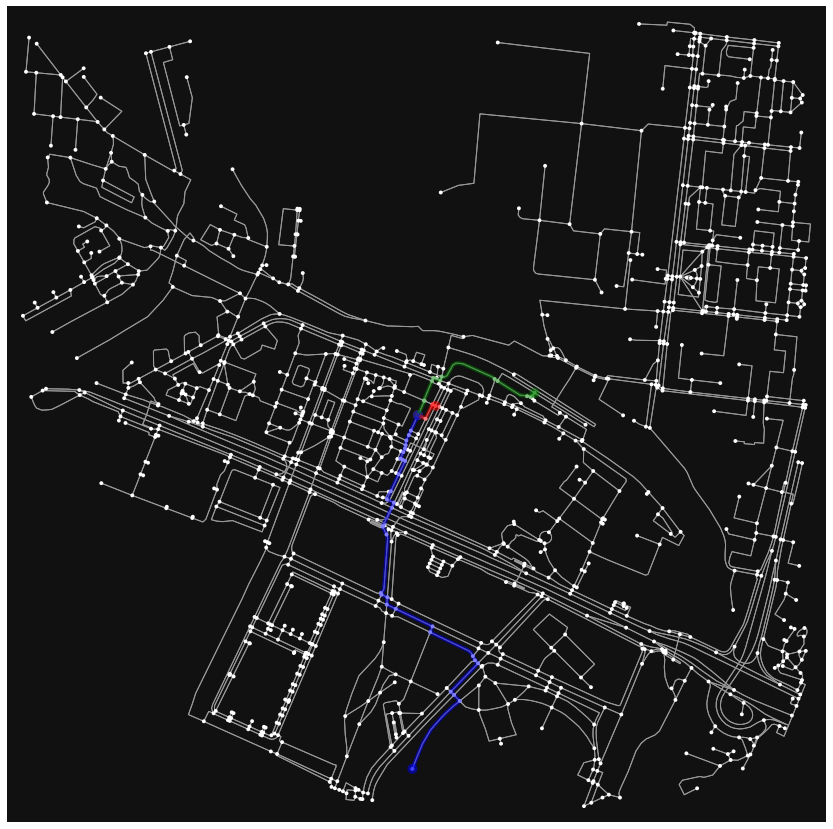

(<Figure size 1440x1080 with 1 Axes>, <AxesSubplot:>)

In [ ]:
# Считаю расстояние до ближайшей станции, и число станций в радиусе 1км (оч долго считается)
n = 19
train = ox.geometries_from_point(center_point=[gdf.lat[n], gdf.lon[n]],  tags={'railway': 'station'}, dist = 1000)  # ищу станции в радиусе 1 км
G = ox.graph.graph_from_point(center_point=[gdf.lat[n], gdf.lon[n]], dist=1000, network_type='walk')
shop_node = ox.distance.get_nearest_node(G, point=[gdf.lat[n], gdf.lon[n]], return_dist=True)  # ближайший узел к магазину

routes = []
for j in range(train.shape[0]):
    try:
        train_node = ox.distance.get_nearest_node(G, point=[train.geometry[j].y, train.geometry[j].x], return_dist=True)  # ближайший узел к станции (станций может быть несколько)
    except:
        train_node = ox.distance.get_nearest_node(G, point=[train.geometry[j].centroid.y, train.geometry[j].centroid.x], return_dist=True)  # ближайший узел к станции (станций может быть несколько)
    route = ox.distance.shortest_path(G, shop_node[0], train_node[0])
    routes.append(route)
ox.plot_graph_routes(G=G, routes=routes, route_colors=['r', 'g', 'b'], figsize = (20, 15))



In [ ]:
import folium
from folium.plugins import HeatMap

m = folium.Map(location=[55, 37], 
               zoom_start=5, 
               tiles='cartodbpositron')

heat_data = [[row['lat'],row['lon']] for index, row in gdf.iterrows()]

HeatMap(heat_data,
        radius=10).add_to(m)  
m  

# Модель

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor

In [ ]:
gdf.head()

,field_1,point_id,lon,lat,target,index_right,NAME,bus_stop_300,railway,n_railway,n_mobile,n_electronics,geometry
0,0,ommNZCUV,37.590776,55.848630,-0.348157,41,Москва,6.0,206.090,14.0,8.0,1.0,POINT (37.59078 55.84863)
1,1,nMe2LHPb,37.784210,55.750271,1.294206,41,Москва,9.0,212.708,7.0,8.0,1.0,POINT (37.78421 55.75027)
2,3,0t2jNYdz,37.704570,55.782020,-1.169339,41,Москва,7.0,3249.310,2.0,11.0,7.0,POINT (37.70457 55.78202)
3,4,U27W4QJ7,37.643983,55.730188,-0.088837,41,Москва,5.0,140.290,21.0,12.0,1.0,POINT (37.64398 55.73019)
4,7,CO76tdVs,37.444304,55.850511,0.213704,41,Москва,6.0,335.011,37.0,8.0,4.0,POINT (37.44430 55.85051)


/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


array([[<AxesSubplot:title={'center':'lon'}>,
        <AxesSubplot:title={'center':'lat'}>,
        <AxesSubplot:title={'center':'target'}>],
       [<AxesSubplot:title={'center':'bus_stop_300'}>,
        <AxesSubplot:title={'center':'railway'}>,
        <AxesSubplot:title={'center':'n_railway'}>],
       [<AxesSubplot:title={'center':'n_mobile'}>,
        <AxesSubplot:title={'center':'n_electronics'}>, <AxesSubplot:>]],
      dtype=object)

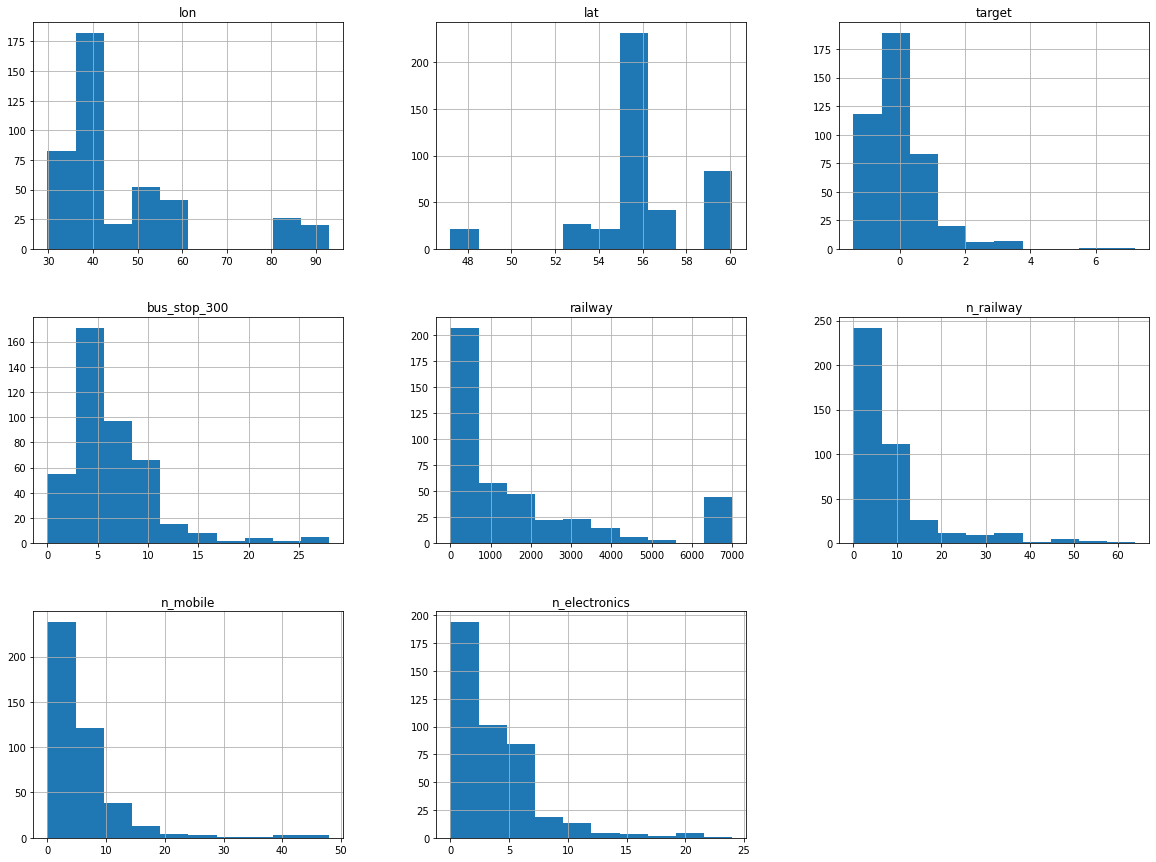

In [ ]:
gdf.hist(figsize=(20, 15))

In [ ]:
gdf = gdf.iloc[gdf.target.values < 4, :]

In [ ]:
features = ['NAME',	'bus_stop_300',	'railway', 'n_railway', 'n_mobile', 'n_electronics']

In [ ]:
ct = ColumnTransformer([
                         ('OneHotEncoder', OneHotEncoder(dtype='int'), ['NAME'])],
                        remainder='passthrough')

In [ ]:
X = ct.fit_transform(gdf[features])
y = gdf.target.values

In [ ]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X, y, random_state = 42)

In [ ]:
model = Pipeline([
                  ('StandardScaler', StandardScaler()),
                  ('svm', SVR(C=0.001, kernel='rbf'))
                #   ('RandomForest', RandomForestRegressor(n_estimators=100, criterion='mae', max_depth=4))
                #   ('SGD', SGDRegressor(loss = 'huber'))
                #   ('LinearRegerssion', LinearRegression())
])

In [ ]:
model.fit(X_train, Y_train)
pred_train = model.predict(X_train)
pred_test = model.predict(X_valid)
print(mean_absolute_error(pred_train, Y_train))
print(mean_absolute_error(pred_test, Y_valid))

0.6269402162979888
0.6948380222436398


In [ ]:
submit = pd.read_csv('submission.csv')

In [ ]:
X_test = ct.transform(test_gdf[features])
pred = model.predict(X_test)
submit.target = pred

In [ ]:
submit.to_csv('submit.csv', index=False)